In [1]:
import os
import random
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import timm
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader

import torchmetrics

from transformers import AutoModel, AutoTokenizer

from dataset import MultimodalDataset, collate_fn, get_transforms
from config import Config as config

tokenizer = AutoTokenizer.from_pretrained(config.TEXT_MODEL_NAME)

c:\Users\OMEN\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Загрузка данных
transforms = get_transforms(config)
val_transforms = get_transforms(config, ds_type="val")
train_dataset = MultimodalDataset(config, transforms)
val_dataset = MultimodalDataset(config, val_transforms, ds_type="val")
train_loader = DataLoader(train_dataset,
                            batch_size=config.BATCH_SIZE,
                            shuffle=True,
                            collate_fn=partial(collate_fn,
                                                tokenizer=tokenizer))
val_loader = DataLoader(val_dataset,
                        batch_size=config.BATCH_SIZE,
                        shuffle=False,
                        collate_fn=partial(collate_fn,
                                            tokenizer=tokenizer))

In [3]:
print(len(train_dataset))

2755


ЗАГРУЗКА ДАННЫХ И АНАЛИЗ

СТАТИСТИКА: TRAIN DATASET
Размер датасета: 2755 примеров

--- КАЛОРИЙНОСТЬ ---
Минимум: 0.0 ккал
Максимум: 3943.3 ккал
Среднее: 254.9 ккал
Медиана: 208.1 ккал
Стандартное отклонение: 221.0 ккал

--- МАССА БЛЮД ---
Минимум: 5.0 г
Максимум: 3051.0 г
Среднее: 218.0 г
Медиана: 179.0 г

--- ИНГРЕДИЕНТЫ ---
Среднее количество ингредиентов: 7.4
Максимум ингредиентов: 34
Минимум ингредиентов: 1
Уникальных dish_id: 2755

--- ПЛОТНОСТЬ КАЛОРИЙ ---
Средняя плотность: 1.28 ккал/г
Диапазон плотности: 0.00 - 5.78 ккал/г

СТАТИСТИКА: VALIDATION DATASET
Размер датасета: 507 примеров

--- КАЛОРИЙНОСТЬ ---
Минимум: 0.0 ккал
Максимум: 1050.5 ккал
Среднее: 255.5 ккал
Медиана: 226.0 ккал
Стандартное отклонение: 212.2 ккал

--- МАССА БЛЮД ---
Минимум: 1.0 г
Максимум: 871.0 г
Среднее: 198.5 г
Медиана: 161.0 г

--- ИНГРЕДИЕНТЫ ---
Среднее количество ингредиентов: 7.1
Максимум ингредиентов: 31
Минимум ингредиентов: 1
Уникальных dish_id: 507

--- ПЛОТНОСТЬ КАЛОРИЙ ---
Средняя плотность

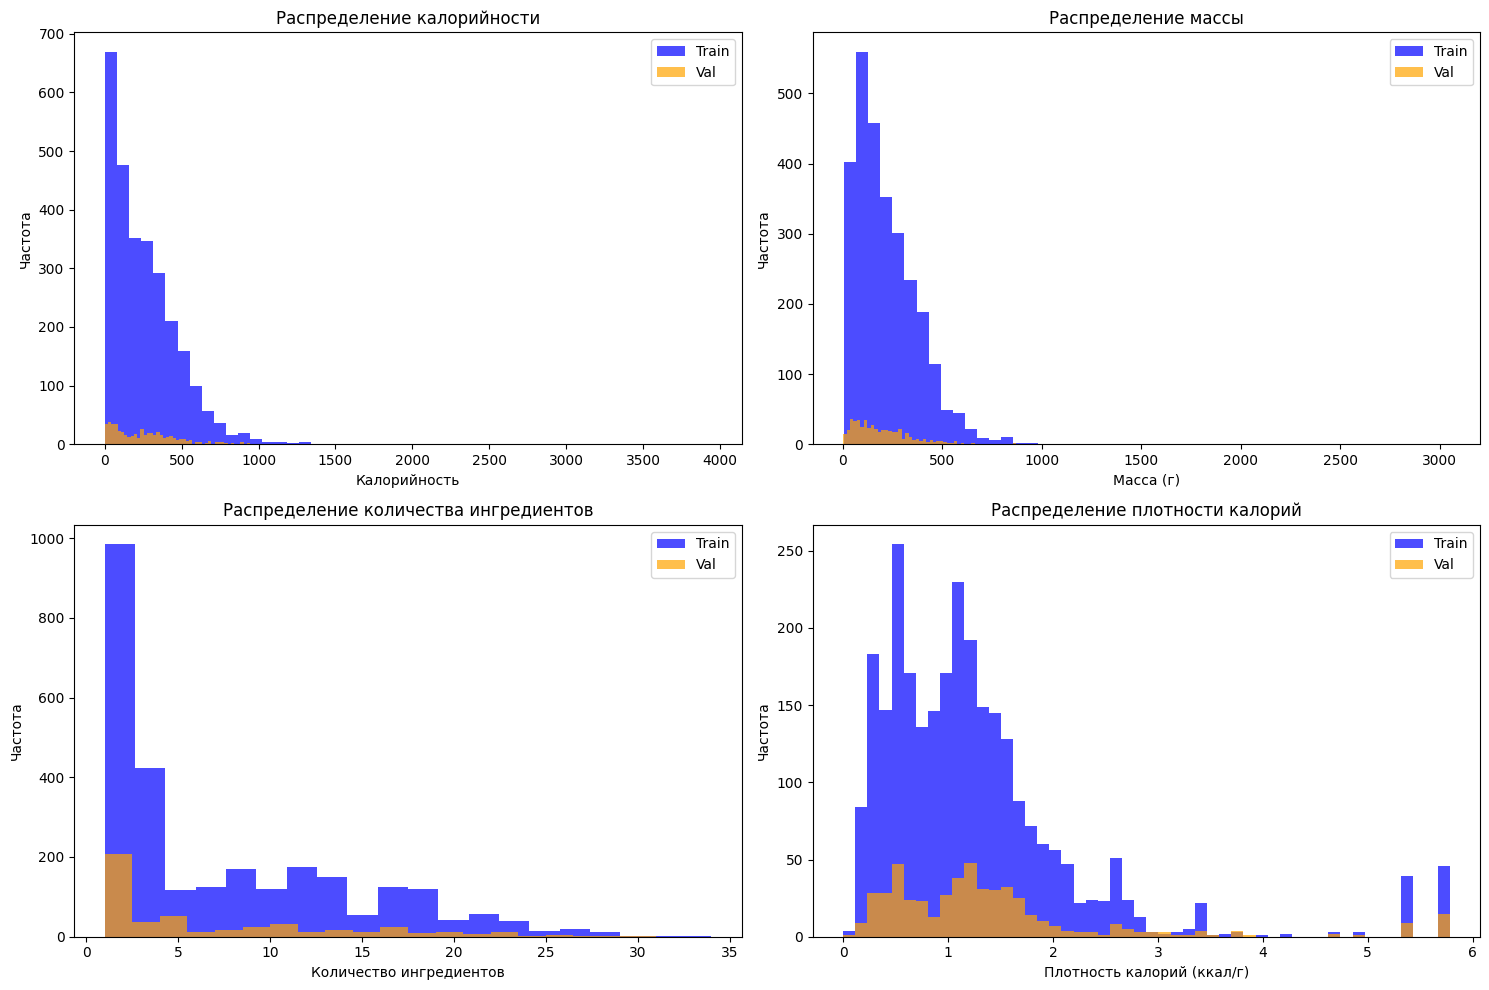


АНАЛИЗ ПЕРВОГО БАТЧА ИЗ TRAIN_LOADER

Размер батча: 256
Ключи в батче: ['labels', 'images', 'input_ids', 'attention_mask', 'total_mass']

--- РАЗМЕРЫ ТЕНЗОРОВ ---
Калории (labels): torch.Size([256])
Изображения (images): torch.Size([256, 3, 224, 224])
Ингредиенты (input_ids): torch.Size([256, 84])
Маска внимания: torch.Size([256, 84])
Масса: torch.Size([256])

ПРИМЕРЫ ИЗ БАТЧА (первые 3)

--- Пример 1 ---
Калорийность: 115.4 ккал
Масса: 61.0 г
Ингредиенты: bell peppers ; garlic ; salt ; cucumbers ; olive oil ; mustard ; vinegar ; radishes
Размер изображения: torch.Size([3, 224, 224])
Диапазон значений изображения: [-2.015, 0.688]
Длина последовательности: 23 токенов
Маска внимания: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...

--- Пример 2 ---
Калорийность: 525.4 ккал
Масса: 297.0 г
Ингредиенты: mixed greens ; steak
Размер изображения: torch.Size([3, 224, 224])
Диапазон значений изображения: [-1.895, 1.821]
Длина последовательности: 6 токенов
Маска внимания: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]...

--

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from functools import partial

def print_dataset_statistics(dataset, name="Dataset"):
    """Печать подробной статистики датасета"""
    print(f"\n{'='*50}")
    print(f"СТАТИСТИКА: {name}")
    print(f"{'='*50}")
    
    # Основная информация
    print(f"Размер датасета: {len(dataset)} примеров")
    
    # Статистика по калориям
    calories = dataset.df["total_calories"]
    print(f"\n--- КАЛОРИЙНОСТЬ ---")
    print(f"Минимум: {calories.min():.1f} ккал")
    print(f"Максимум: {calories.max():.1f} ккал")
    print(f"Среднее: {calories.mean():.1f} ккал")
    print(f"Медиана: {calories.median():.1f} ккал")
    print(f"Стандартное отклонение: {calories.std():.1f} ккал")
    
    # Статистика по массе
    masses = dataset.df["total_mass"]
    print(f"\n--- МАССА БЛЮД ---")
    print(f"Минимум: {masses.min():.1f} г")
    print(f"Максимум: {masses.max():.1f} г")
    print(f"Среднее: {masses.mean():.1f} г")
    print(f"Медиана: {masses.median():.1f} г")
    
    # Статистика по ингредиентам
    ingredients = dataset.df["processed_ingredients"]
    ingredient_counts = ingredients.str.split(';').str.len()
    print(f"\n--- ИНГРЕДИЕНТЫ ---")
    print(f"Среднее количество ингредиентов: {ingredient_counts.mean():.1f}")
    print(f"Максимум ингредиентов: {ingredient_counts.max()}")
    print(f"Минимум ингредиентов: {ingredient_counts.min()}")
    
    # Уникальные блюда
    print(f"Уникальных dish_id: {dataset.df['dish_id'].nunique()}")
    
    # Плотность калорий (калории на грамм)
    density = calories / masses
    print(f"\n--- ПЛОТНОСТЬ КАЛОРИЙ ---")
    print(f"Средняя плотность: {density.mean():.2f} ккал/г")
    print(f"Диапазон плотности: {density.min():.2f} - {density.max():.2f} ккал/г")

def print_batch_examples(batch, tokenizer, num_examples=3):
    """Печать примеров из батча"""
    print(f"\n{'='*40}")
    print(f"ПРИМЕРЫ ИЗ БАТЧА (первые {num_examples})")
    print(f"{'='*40}")
    
    for i in range(min(num_examples, len(batch["labels"]))):
        print(f"\n--- Пример {i+1} ---")
        print(f"Калорийность: {batch['labels'][i].item():.1f} ккал")
        print(f"Масса: {batch['total_mass'][i].item():.1f} г")
        
        # Декодируем ингредиенты
        ingredient_ids = batch["input_ids"][i]
        # Убираем паддинг (токены с ID=0)
        non_padding_mask = ingredient_ids != tokenizer.pad_token_id
        actual_tokens = ingredient_ids[non_padding_mask]
        ingredients_text = tokenizer.decode(actual_tokens, skip_special_tokens=True)
        print(f"Ингредиенты: {ingredients_text}")
        
        # Информация об изображении
        image = batch["images"][i]
        print(f"Размер изображения: {image.shape}")
        print(f"Диапазон значений изображения: [{image.min():.3f}, {image.max():.3f}]")
        
        # Attention mask
        attention_mask = batch["attention_mask"][i]
        print(f"Длина последовательности: {attention_mask.sum().item()} токенов")
        print(f"Маска внимания: {attention_mask.tolist()[:10]}...")  # первые 10 элементов

def visualize_distributions(train_dataset, val_dataset):
    """Визуализация распределений данных"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Распределение калорий
    axes[0, 0].hist(train_dataset.df["total_calories"], bins=50, alpha=0.7, label='Train', color='blue')
    axes[0, 0].hist(val_dataset.df["total_calories"], bins=50, alpha=0.7, label='Val', color='orange')
    axes[0, 0].set_xlabel('Калорийность')
    axes[0, 0].set_ylabel('Частота')
    axes[0, 0].set_title('Распределение калорийности')
    axes[0, 0].legend()
    
    # Распределение массы
    axes[0, 1].hist(train_dataset.df["total_mass"], bins=50, alpha=0.7, label='Train', color='blue')
    axes[0, 1].hist(val_dataset.df["total_mass"], bins=50, alpha=0.7, label='Val', color='orange')
    axes[0, 1].set_xlabel('Масса (г)')
    axes[0, 1].set_ylabel('Частота')
    axes[0, 1].set_title('Распределение массы')
    axes[0, 1].legend()
    
    # Количество ингредиентов
    train_ing_count = train_dataset.df["processed_ingredients"].str.split(';').str.len()
    val_ing_count = val_dataset.df["processed_ingredients"].str.split(';').str.len()
    
    axes[1, 0].hist(train_ing_count, bins=20, alpha=0.7, label='Train', color='blue')
    axes[1, 0].hist(val_ing_count, bins=20, alpha=0.7, label='Val', color='orange')
    axes[1, 0].set_xlabel('Количество ингредиентов')
    axes[1, 0].set_ylabel('Частота')
    axes[1, 0].set_title('Распределение количества ингредиентов')
    axes[1, 0].legend()
    
    # Плотность калорий
    train_density = train_dataset.df["total_calories"] / train_dataset.df["total_mass"]
    val_density = val_dataset.df["total_calories"] / val_dataset.df["total_mass"]
    
    axes[1, 1].hist(train_density, bins=50, alpha=0.7, label='Train', color='blue')
    axes[1, 1].hist(val_density, bins=50, alpha=0.7, label='Val', color='orange')
    axes[1, 1].set_xlabel('Плотность калорий (ккал/г)')
    axes[1, 1].set_ylabel('Частота')
    axes[1, 1].set_title('Распределение плотности калорий')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Основной код загрузки данных с статистикой
print("ЗАГРУЗКА ДАННЫХ И АНАЛИЗ")
print("="*60)

# Загрузка данных
transforms = get_transforms(config)
val_transforms = get_transforms(config, ds_type="val")
train_dataset = MultimodalDataset(config, transforms)
val_dataset = MultimodalDataset(config, val_transforms, ds_type="val")

# Печать статистики
print_dataset_statistics(train_dataset, "TRAIN DATASET")
print_dataset_statistics(val_dataset, "VALIDATION DATASET")

# Визуализация распределений
visualize_distributions(train_dataset, val_dataset)

# Создание DataLoader'ов
train_loader = DataLoader(train_dataset,
                         batch_size=config.BATCH_SIZE,
                         shuffle=True,
                         collate_fn=partial(collate_fn, tokenizer=tokenizer))
val_loader = DataLoader(val_dataset,
                       batch_size=config.BATCH_SIZE,
                       shuffle=False,
                       collate_fn=partial(collate_fn, tokenizer=tokenizer))

# Анализ первого батча из train_loader
print("\n" + "="*60)
print("АНАЛИЗ ПЕРВОГО БАТЧА ИЗ TRAIN_LOADER")
print("="*60)

for i, batch in enumerate(train_loader):
    if i == 0:  # Только первый батч
        print(f"\nРазмер батча: {config.BATCH_SIZE}")
        print(f"Ключи в батче: {list(batch.keys())}")
        
        # Общая информация о тензорах
        print(f"\n--- РАЗМЕРЫ ТЕНЗОРОВ ---")
        print(f"Калории (labels): {batch['labels'].shape}")
        print(f"Изображения (images): {batch['images'].shape}")
        print(f"Ингредиенты (input_ids): {batch['input_ids'].shape}")
        print(f"Маска внимания: {batch['attention_mask'].shape}")
        print(f"Масса: {batch['total_mass'].shape}")
        
        # Подробные примеры
        print_batch_examples(batch, tokenizer, num_examples=3)
        
        # Статистика по батчу
        print(f"\n--- СТАТИСТИКА БАТЧА ---")
        print(f"Калории - мин: {batch['labels'].min().item():.1f}, макс: {batch['labels'].max().item():.1f}")
        print(f"Масса - мин: {batch['total_mass'].min().item():.1f}, макс: {batch['total_mass'].max().item():.1f}")
        print(f"Изображения - диапазон: [{batch['images'].min().item():.3f}, {batch['images'].max().item():.3f}]")
        
        break  # Только первый батч

# Анализ валидационного загрузчика
print("\n" + "="*60)
print("ИНФОРМАЦИЯ О DATA LOADER'АХ")
print("="*60)
print(f"Train DataLoader: {len(train_loader)} батчей по {config.BATCH_SIZE} примеров")
print(f"Val DataLoader: {len(val_loader)} батчей по {config.BATCH_SIZE} примеров")
print(f"Всего примеров в train: {len(train_dataset)}")
print(f"Всего примеров в val: {len(val_dataset)}")

# Проверка совместимости с моделью
print(f"\n--- ПРОВЕРКА СОВМЕСТИМОСТИ ---")
print(f"Тип labels: {batch['labels'].dtype} (должен быть torch.float32)")
print(f"Тип images: {batch['images'].dtype} (должен быть torch.float32)")
print(f"Тип input_ids: {batch['input_ids'].dtype} (должен быть torch.int64)")